# Hackathon Reproducibility: Pre-Symptoms Model Training & Evaluation

**Pipeline**: Pyannote transcription → MedGemma text+acoustic narrative embeddings (2560-dim per clip) → speaker-level aggregation [mean, std] = 5120 dims → LogisticRegression classifier

**Raw audio** is supplied in `dataset/audio/`. Here we demonstrate model training from pre-extracted MedGemma embeddings stored in `reproducibility/multimodal/`.

---

## Reproducibility levels

This repository offers three levels of reproducibility, from quickest to most thorough:

| Level | What to do | Time | Requirements |
|-------|------------|------|--------------|
| **1. Evaluate** | Load the supplied model (`.pkl`) and embeddings (`.npz`), score speakers | ~10 seconds | numpy, scikit-learn, pandas |
| **2. Retrain** | Load supplied embeddings, retrain the classifier from scratch | ~30 seconds | numpy, scikit-learn, pandas |
| **3. Full re-extraction** | Re-extract embeddings from audio via MedGemma, then retrain | ~2–4 hours | GPU, torch, transformers, librosa, bitsandbytes |

Levels 1 and 2 rely on **pre-computed artefacts** already included in this repository.
Level 3 requires a GPU with ≥16 GB VRAM and a Hugging Face token with access to `google/medgemma-4b-it`.

> **Note on transcripts**: For convenience, Pyannote precision-2 + parakeet-tdt-0.6b-v3
> transcripts used during training are included at `reproducibility/transcripts/manifest_transcripts.json`.
> These transcripts will remain available in the repository until **31 March 2026**. After that date,
> they can be regenerated from the audio files using Pyannote (see `code/extract_embeddings.py` for details).

## Level 1: Evaluate with the supplied model (quickest)

Load the pre-trained model (`.pkl`) and pre-extracted embeddings (`.npz`), aggregate to speaker level, and score — this is the quickest way to verify the reported metrics.

In [ ]:
import os, pickle
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

ROOT = Path('..').resolve()
MANIFEST_PATH = ROOT / 'dataset' / 'manifest.csv'
MODEL_PKL = ROOT / 'reproducibility' / 'best_model' / 'text_acoustic_narrative_pre_symptoms.pkl'
TAN_NPZ = (
    ROOT / 'reproducibility' / 'multimodal'
    / 'outputs_multimodal_agentic_manifest_text_acoustic_narrative'
    / 'multimodal_embeddings_agentic_manifest_text_acoustic_narrative.npz'
)

# Load pre-trained model bundle (scaler + classifier)
with open(MODEL_PKL, 'rb') as f:
    bundle = pickle.load(f)
scaler = bundle['scaler']
clf = bundle['classifier']
print(f'Model loaded: {MODEL_PKL.name}')
print(f'  Classifier: {clf.__class__.__name__}, coef shape: {clf.coef_.shape}')

# Load manifest and embeddings
manifest = pd.read_csv(MANIFEST_PATH)
manifest_map = {}
for _, row in manifest.iterrows():
    stem = os.path.splitext(str(row['anon_filename']))[0]
    manifest_map[stem] = {'speaker_id': str(row['anon_speaker_id']), 'label': int(row['label'])}

pack = np.load(TAN_NPZ, allow_pickle=True)['conditions'].item()
tan_clip = {k: np.asarray(v, dtype=np.float32)
            for k, v in pack['text_plus_acoustic_narrative'].items()}

# Filter pre-symptoms only, aggregate to speaker level [mean, std]
pre_clips = [c for c in sorted(tan_clip) if '_after_symptoms_' not in c.lower()]
by_spk = defaultdict(lambda: {'x': [], 'y': None})
for clip in pre_clips:
    info = manifest_map.get(clip)
    if info is None:
        continue
    by_spk[info['speaker_id']]['x'].append(tan_clip[clip])
    by_spk[info['speaker_id']]['y'] = info['label']

X_list, y_list = [], []
for sid in sorted(by_spk):
    arr = np.stack(by_spk[sid]['x'])
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0) if arr.shape[0] > 1 else np.zeros_like(mean)
    X_list.append(np.concatenate([mean, std]))
    y_list.append(by_spk[sid]['y'])

X_spk = np.stack(X_list).astype(np.float32)
y_spk = np.array(y_list)

# Score using the pre-trained model
X_scaled = scaler.transform(X_spk)
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
probs = clf.predict_proba(X_scaled)[:, 1]
preds = (probs >= 0.5).astype(int)

print(f'\nLevel 1 — Evaluate with supplied model')
print(f'  Speakers: {len(y_spk)} ({int(y_spk.sum())} dementia, {int((1-y_spk).sum())} control)')
print(f'  AUC:      {roc_auc_score(y_spk, probs):.4f}')
print(f'  F1:       {f1_score(y_spk, preds):.4f}')
print(f'  Accuracy: {accuracy_score(y_spk, preds):.4f}')
print(f'\nNote: This is the resubstitution score (trained on all speakers).')
print(f'For unbiased CV metrics, see Level 2 below.')

In [ ]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             roc_auc_score)
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

ROOT = Path('..').resolve()
MANIFEST_PATH = ROOT / 'dataset' / 'manifest.csv'
TAN_NPZ = (
    ROOT / 'reproducibility' / 'multimodal'
    / 'outputs_multimodal_agentic_manifest_text_acoustic_narrative'
    / 'multimodal_embeddings_agentic_manifest_text_acoustic_narrative.npz'
)

RANDOM_STATE = 42
THRESHOLD = 0.5

---

## Level 2: Retrain the classifier from supplied embeddings

Re-run the full 5-fold GroupKFold cross-validation from scratch using the pre-extracted MedGemma embeddings. This reproduces the unbiased CV metrics (AUC 0.9112) independently.

### 2.1 Load embeddings & manifest, filter pre-symptoms only

In [2]:
# Load manifest
manifest = pd.read_csv(MANIFEST_PATH)
manifest_map = {}
for _, row in manifest.iterrows():
    stem = os.path.splitext(str(row['anon_filename']))[0]
    manifest_map[stem] = {
        'speaker_id': str(row['anon_speaker_id']),
        'label': int(row['label']),
    }

# Load MedGemma text+acoustic narrative embeddings
pack = np.load(TAN_NPZ, allow_pickle=True)['conditions'].item()
tan_clip = {k: np.asarray(v, dtype=np.float32)
            for k, v in pack['text_plus_acoustic_narrative'].items()}

# Filter: keep only pre-symptoms clips (exclude after_symptoms)
all_clips = sorted(tan_clip.keys())
pre_symptoms_clips = [c for c in all_clips if '_after_symptoms_' not in c.lower()]
n_excluded = len(all_clips) - len(pre_symptoms_clips)

print(f'Total clips: {len(all_clips)}')
print(f'Excluded after-symptoms: {n_excluded}')
print(f'Pre-symptoms clips: {len(pre_symptoms_clips)}')

Total clips: 2843
Excluded after-symptoms: 272
Pre-symptoms clips: 2571


### 2.2 Aggregate to speaker level: [mean(2560), std(2560)] = 5120 dims

In [3]:
# Build clip-level arrays
X_list, y_list, g_list = [], [], []
for clip_name in sorted(pre_symptoms_clips):
    info = manifest_map.get(clip_name)
    if info is None:
        continue
    X_list.append(tan_clip[clip_name])
    y_list.append(info['label'])
    g_list.append(info['speaker_id'])

X_clip = np.asarray(X_list, dtype=np.float32)
y_clip = np.asarray(y_list, dtype=np.int64)
g_clip = np.asarray(g_list)

# Aggregate to speaker level
by_spk = defaultdict(lambda: {'x': [], 'y': None})
for i, sid in enumerate(g_clip):
    by_spk[sid]['x'].append(X_clip[i])
    by_spk[sid]['y'] = int(y_clip[i])

X_spk_list, y_spk_list, g_spk_list = [], [], []
for sid, row in sorted(by_spk.items()):
    arr = np.stack(row['x'], axis=0)
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0) if arr.shape[0] > 1 else np.zeros_like(mean)
    X_spk_list.append(np.concatenate([mean, std]).astype(np.float32))
    y_spk_list.append(row['y'])
    g_spk_list.append(sid)

X_spk = np.stack(X_spk_list, axis=0)
y_spk = np.asarray(y_spk_list, dtype=np.int64)
g_spk = np.asarray(g_spk_list)

n_dementia = int(np.sum(y_spk == 1))
n_control = int(np.sum(y_spk == 0))
print(f'Speakers: {len(y_spk)} ({n_dementia} dementia, {n_control} control)')
print(f'Speaker feature dim: {X_spk.shape[1]}')

Speakers: 188 (84 dementia, 104 control)
Speaker feature dim: 5120


### 2.3 Train model & 5-fold GroupKFold cross-validation

In [4]:
# 5-fold GroupKFold CV (speaker-grouped, no speaker leakage)
gkf = GroupKFold(n_splits=5)
fold_aucs = []
y_true_all, p_all, g_all, fold_all = [], [], [], []

for fold_id, (tr, te) in enumerate(gkf.split(X_spk, y_spk, g_spk), 1):
    Xtr, Xte = X_spk[tr], X_spk[te]
    ytr, yte = y_spk[tr], y_spk[te]

    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xte = scaler.transform(Xte)
    Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
    Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

    clf = LogisticRegression(
        max_iter=2000, C=1.0, class_weight='balanced',
        solver='saga', penalty='l2', random_state=RANDOM_STATE,
    )
    clf.fit(Xtr, ytr)
    p = clf.predict_proba(Xte)[:, 1]

    fold_auc = roc_auc_score(yte, p)
    fold_aucs.append(fold_auc)
    y_true_all.append(yte)
    p_all.append(p)
    g_all.append(g_spk[te])
    fold_all.append(np.full(len(te), fold_id))

y_oof = np.concatenate(y_true_all)
p_oof = np.concatenate(p_all)
y_pred_oof = (p_oof >= THRESHOLD).astype(np.int64)

print(f'5-fold GroupKFold CV AUC: {np.mean(fold_aucs):.4f} +/- {np.std(fold_aucs):.4f}')
print(f'Per-fold: {[f"{a:.4f}" for a in fold_aucs]}')
print(f'OOF F1:       {f1_score(y_oof, y_pred_oof, zero_division=0):.4f}')
print(f'OOF Accuracy: {accuracy_score(y_oof, y_pred_oof):.4f}')

5-fold GroupKFold CV AUC: 0.9112 +/- 0.0420
Per-fold: ['0.9071', '0.9472', '0.8667', '0.8655', '0.9697']
OOF F1:       0.8293
OOF Accuracy: 0.8511


### 2.4 Results: metrics bar chart

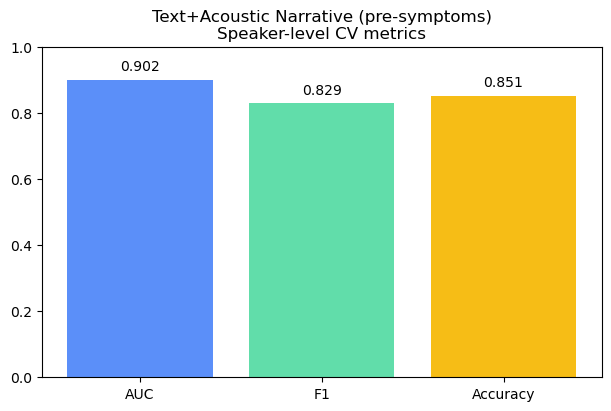

In [5]:
auc_val = roc_auc_score(y_oof, p_oof)
f1_val = f1_score(y_oof, y_pred_oof, zero_division=0)
acc_val = accuracy_score(y_oof, y_pred_oof)

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
metric_names = ['AUC', 'F1', 'Accuracy']
vals = [auc_val, f1_val, acc_val]
bars = ax.bar(metric_names, vals, color=['#5B8FF9', '#61DDAA', '#F6BD16'])
ax.set_ylim(0.0, 1.0)
ax.set_title('Text+Acoustic Narrative (pre-symptoms)\nSpeaker-level CV metrics')
for i, v in enumerate(vals):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
plt.show()

### 2.5 Confusion matrix

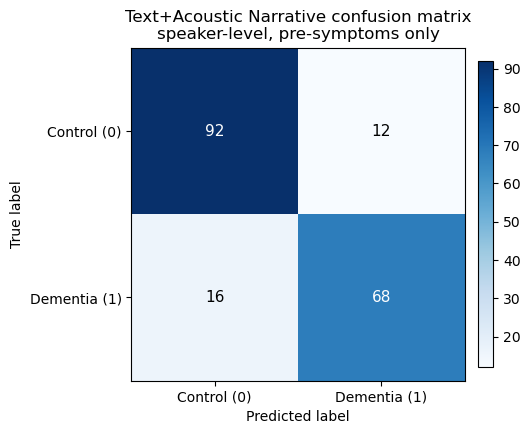

TN=92  FP=12
FN=16  TP=68


In [6]:
cm = confusion_matrix(y_oof, y_pred_oof, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5.2, 4.8), constrained_layout=True)
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks([0, 1], ['Control (0)', 'Dementia (1)'])
ax.set_yticks([0, 1], ['Control (0)', 'Dementia (1)'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Text+Acoustic Narrative confusion matrix\nspeaker-level, pre-symptoms only')

max_v = max(cm.max(), 1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > max_v * 0.5 else 'black'
        ax.text(j, i, str(int(cm[i, j])), ha='center', va='center',
                color=color, fontsize=11)
plt.show()

print(f'TN={cm[0,0]}  FP={cm[0,1]}')
print(f'FN={cm[1,0]}  TP={cm[1,1]}')

### 2.6 OOF speaker predictions

In [7]:
oof_df = pd.DataFrame({
    'speaker_id': np.concatenate(g_all),
    'fold': np.concatenate(fold_all).astype(int),
    'y_true': y_oof,
    'probability': np.round(p_oof, 4),
    'y_pred': y_pred_oof,
}).sort_values('speaker_id').reset_index(drop=True)

oof_df

,speaker_id,fold,y_true,probability,y_pred
0,SUBJ_0001,3,1,0.9656,1
1,SUBJ_0002,2,1,0.9618,1
2,SUBJ_0003,1,0,0.0000,0
3,SUBJ_0004,5,0,0.0036,0
4,SUBJ_0005,4,1,0.9994,1
...,...,...,...,...,...
183,SUBJ_0209,5,0,0.0873,0
184,SUBJ_0210,4,1,0.1863,0
185,SUBJ_0211,3,0,0.0219,0
186,SUBJ_0212,2,0,0.0013,0


---

## Level 3: Full re-extraction from audio

To reproduce the entire pipeline from raw audio, run `code/extract_embeddings.py`. This script:

1. Loads pre-extracted transcripts from `reproducibility/transcripts/manifest_transcripts.json`
2. Loads each audio clip and computes 14 acoustic metrics (librosa)
3. Builds a structured natural-language prompt embedding the transcript and acoustic descriptors
4. Passes the prompt through MedGemma 4B-IT (4-bit quantised, text-only)
5. Mean-pools the last hidden state to produce a 2560-dim embedding per clip
6. Saves all embeddings as a single `.npz` file

```bash
# Requires: GPU with >=16 GB VRAM, HF_TOKEN with access to google/medgemma-4b-it
pip install torch transformers bitsandbytes accelerate librosa numpy pandas
python code/extract_embeddings.py
```

Once the new `.npz` file is generated, re-run Level 2 above (pointing `TAN_NPZ` at the new file) to retrain and evaluate the classifier.

> **Transcript availability**: The supplied transcript cache (`manifest_transcripts.json`) will
> remain in the repository until **31 March 2026**. After that date, transcripts can be
> regenerated from the audio files using Pyannote with the precision-2 segmentation profile
> and parakeet-tdt-0.6b-v3 transcription model.